In [1]:
import os
import tensorflow as tf
import keras
import pandas as pd

In [3]:
zip_path = keras.utils.get_file(
    origin = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip",
    fname = "jena_climate_2009_2016.csv.zip",
    extract = True
)
csv_path, _ = os.path.splitext(zip_path)

13568290/13568290 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
df = pd.read_csv(csv_path)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [5]:
df.shape

(420551, 15)

In [6]:
temperatures = df["T (degC)"]
temperatures.index = df["Date Time"]

<Axes: xlabel='Date Time'>

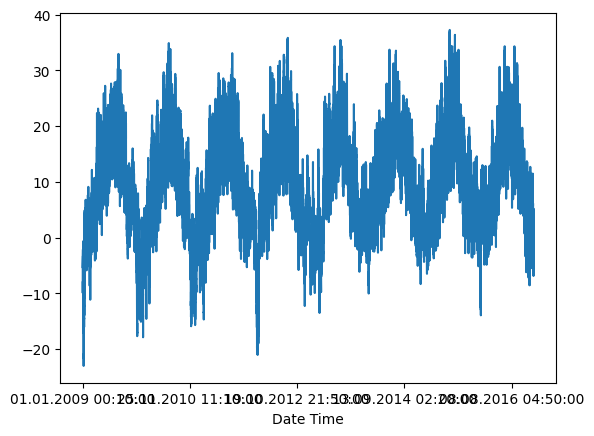

In [7]:
temperatures.plot()

### LSTM 모델 만들기

In [8]:
lstm_layer = keras.layers.LSTM(units = 32)

In [9]:
x = tf.random.normal([2, 24, 1])

In [10]:
y = lstm_layer(x)

In [11]:
y.shape

TensorShape([2, 32])

In [12]:
lstm_layer_seq = keras.layers.LSTM(units=32, return_sequences=True)

In [13]:
y_seq = lstm_layer_seq(x)
y_seq.shape

TensorShape([2, 24, 32])

In [14]:
lstm_model = keras.models.Sequential(
    [
        keras.layers.LSTM(units=32, return_sequences=True),
        keras.layers.Dense(1),
    ]
)

In [15]:
y = lstm_model(x)
y.shape

TensorShape([2, 24, 1])

### 시계열 데이터 전처리

In [16]:
temperatures = df["T (degC)"].tolist()
temperatures = temperatures[:50000]

In [17]:
temperatures[:10]

[-8.02, -8.41, -8.51, -8.31, -8.27, -8.05, -7.62, -7.62, -7.91, -8.43]

In [18]:
num_data = len(temperatures)

train_size = int(num_data * 0.8)
val_size = int(num_data * 0.1)

In [19]:
train_data = temperatures[:train_size]
val_data = temperatures[train_size:train_size + val_size]
test_data = temperatures[train_size + val_size:]

In [20]:
print(f"max: {max(train_data)}, min: {min(train_data)}")

max: 32.98, min: -23.01


In [21]:
normalizer = keras.layers.Normalization(axis = None)
normalizer.adapt(tf.constant(train_data))

In [22]:
train_data_normalized = normalizer(train_data)
val_data_normalized = normalizer(val_data)
test_data_normalized = normalizer(test_data)

In [23]:
print(f"before: {train_data[0]}, after: {train_data_normalized[0].numpy()}")

before: -8.02, after: -2.099597215652466


In [24]:
import numpy as np

def preprocess_data(data, sequence_length):
  data = np.array(data)
  inputs = np.array([data[i:i+sequence_length] for i in range(len(data) - sequence_length)])
  targets = np.array([data[i+1:i+sequence_length+1] for i in range(len(data) - sequence_length)])

  inputs = np.expand_dims(inputs, axis = -1)
  targets = np.expand_dims(targets, axis = -1)

  return inputs, targets

In [25]:
sequence_length = 24
train_inputs, train_targets = preprocess_data(train_data_normalized, sequence_length)
val_inputs, val_targets = preprocess_data(val_data_normalized, sequence_length)
test_inputs, test_targets = preprocess_data(test_data_normalized, sequence_length)

In [26]:
print(f"original: {train_data_normalized[:25]}\n")
print(f"input: {train_inputs[0]}\n")
print(f"target: {train_targets[0]}\n")

original: [-2.0995972 -2.144479  -2.1559873 -2.1329708 -2.1283677 -2.1030498
 -2.0535645 -2.0535645 -2.0869381 -2.1467807 -2.1847577 -2.1985676
 -2.1951153 -2.1928136 -2.1732495 -2.1732495 -2.1778526 -2.190512
 -2.1939645 -2.2054727 -2.2054727 -2.196266  -2.2112267 -2.2181318
 -2.2388463]

input: [[-2.0995972]
 [-2.144479 ]
 [-2.1559873]
 [-2.1329708]
 [-2.1283677]
 [-2.1030498]
 [-2.0535645]
 [-2.0535645]
 [-2.0869381]
 [-2.1467807]
 [-2.1847577]
 [-2.1985676]
 [-2.1951153]
 [-2.1928136]
 [-2.1732495]
 [-2.1732495]
 [-2.1778526]
 [-2.190512 ]
 [-2.1939645]
 [-2.2054727]
 [-2.2054727]
 [-2.196266 ]
 [-2.2112267]
 [-2.2181318]]

target: [[-2.144479 ]
 [-2.1559873]
 [-2.1329708]
 [-2.1283677]
 [-2.1030498]
 [-2.0535645]
 [-2.0535645]
 [-2.0869381]
 [-2.1467807]
 [-2.1847577]
 [-2.1985676]
 [-2.1951153]
 [-2.1928136]
 [-2.1732495]
 [-2.1732495]
 [-2.1778526]
 [-2.190512 ]
 [-2.1939645]
 [-2.2054727]
 [-2.2054727]
 [-2.196266 ]
 [-2.2112267]
 [-2.2181318]
 [-2.2388463]]



In [27]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_targets)).shuffle(512).batch(128, drop_remainder = True)
val_dataset = tf.data.Dataset.from_tensor_slices((val_inputs, val_targets)).batch(128)
test_dataset = tf.data.Dataset.from_tensor_slices((test_inputs, test_targets)).batch(128)

### 시계열 예측 모델 학습

In [28]:
zip_path = keras.utils.get_file(
    origin = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip",
    fname = "jena_climate_2009_2016.csv.zip",
    extract = True
)
csv_path, _ = os.path.splitext(zip_path)

df = pd.read_csv(csv_path)

temperatures = df["T (degC)"].tolist()
temperatures = temperatures[:50000]

In [29]:
num_data = len(temperatures)

train_size = int(num_data * 0.8)
val_size = int(num_data * 0.1)

train_data = temperatures[:train_size]
val_data = temperatures[train_size:train_size + val_size]
test_data = temperatures[train_size + val_size:]

def preprocess_data(data, sequence_length):
  data = np.array(data)
  inputs = np.array([data[i:i+sequence_length] for i in range(len(data) - sequence_length)])
  targets = np.array([data[i+1:i+sequence_length+1] for i in range(len(data) - sequence_length)])

  inputs = np.expand_dims(inputs, axis = -1)
  targets = np.expand_dims(targets, axis = -1)

  return inputs, targets

  sequence_length = 24
train_inputs, train_targets = preprocess_data(train_data_normalized, sequence_length)
val_inputs, val_targets = preprocess_data(val_data_normalized, sequence_length)
test_inputs, test_targets = preprocess_data(test_data_normalized, sequence_length)

In [30]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_targets)).shuffle(512).batch(128, drop_remainder = True)
val_dataset = tf.data.Dataset.from_tensor_slices((val_inputs, val_targets)).batch(128)
test_dataset = tf.data.Dataset.from_tensor_slices((test_inputs, test_targets)).batch(128)

In [31]:
model = keras.models.Sequential(
    [
        keras.layers.LSTM(units=32, return_sequences=True),
        keras.layers.Dense(1),
    ]
)

In [32]:
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam()
metric = keras.metrics.MeanAbsoluteError()

In [34]:
@tf.function
def train_step(x, y):
  with tf.GradientTape() as tape:
    logits = model(x, training = True)
    loss_value = loss_fn(y, logits)
  grads = tape.gradient(loss_value, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  return loss_value

@tf.function
def val_step(x, y):
  val_preds = model(x_val, training = False)
  metric.update_state(y_val, val_preds)

In [35]:
epochs = 10
step = 0
for epoch in range(epochs):
  for x_train, y_train in train_dataset:
    loss_value = train_step(x_train, y_train)
    step += 1

    if step % 100 == 0:
      print(f"train loss at step {step}: {loss_value:.4f}")

  for x_val, y_val in val_dataset:
    val_step(x_val, y_val)

  print(f"validation metric at epoch {epoch}: {metric.result():.4f}\n")
  metric.reset_state()

train loss at step 100: 0.0453
train loss at step 200: 0.0894
train loss at step 300: 0.0225
validation metric at epoch 0: 0.0706

train loss at step 400: 0.0253
train loss at step 500: 0.0247
train loss at step 600: 0.0103
validation metric at epoch 1: 0.0491

train loss at step 700: 0.0172
train loss at step 800: 0.0091
train loss at step 900: 0.0181
validation metric at epoch 2: 0.0387

train loss at step 1000: 0.0108
train loss at step 1100: 0.0117
train loss at step 1200: 0.0270
validation metric at epoch 3: 0.0325

train loss at step 1300: 0.0277
train loss at step 1400: 0.0064
train loss at step 1500: 0.0138
validation metric at epoch 4: 0.0273

train loss at step 1600: 0.0104
train loss at step 1700: 0.0034
train loss at step 1800: 0.0097
validation metric at epoch 5: 0.0237

train loss at step 1900: 0.0106
train loss at step 2000: 0.0032
train loss at step 2100: 0.0065
validation metric at epoch 6: 0.0209

train loss at step 2200: 0.0132
train loss at step 2300: 0.0028
train l

In [37]:
predictions = model.predict(test_dataset)

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step


In [38]:
predictions.shape

(4976, 24, 1)

In [39]:
denormalizer = keras.layers.Normalization(axis = None, invert = True)
denormalizer.adapt(tf.constant(train_data))

In [40]:
pred_denorm = denormalizer(predictions)
true_denorm = denormalizer(test_targets)

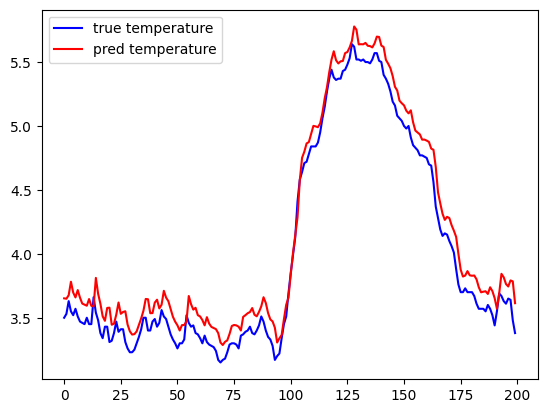

In [41]:
import matplotlib.pyplot as plt

num_steps = 200
plt.plot(true_denorm[:num_steps, -1], color = "blue", label = "true temperature")
plt.plot(pred_denorm[:num_steps, -1], color = "red", label = "pred temperature")
plt.legend()
plt.show()